In [ ]:
!nvidia-smi

Mon Sep  6 05:22:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1_101-all-classes.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "All-classes-Full-UTK-CORAL_ResNet152-100%-Pretrained-Finetuned-EPOCHS-200-withoutLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 101
BATCH_SIZE = 64
EPOCHS = 100
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-06 11:22:38.816088+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: All-classes-Full-UTK-CORAL_ResNet152-100%-Pretrained-Finetuned-EPOCHS-200-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_ResNet152-100%-Pretrained-Finetuned-EPOCHS-200-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 64
Grayscale: False
Learning Rate: 0.0005
Epochs: 100


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
print(labels.size())

torch.Size([23689])


In [ ]:
# uniq = torch.unique(labels) #1-101, !94,97,98
# # print(uniq)
# num_examples = labels.size(0) #23689
# # print(num_examples)

# """# m = torch.zeros(uniq.shape[0]) #tensor of 98 zeros"""
# m = torch.zeros(int(torch.max(labels).item())) #tensor of 101 zeros
# # print(m.shape)

# j=27
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# # print(lol) #1-100
# x = torch.tensor(labels[labels > j]).size(0)
# # print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# # print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# # print(a)
# max = torch.max(a)
# # print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# # print(root) # square root of max of a

# for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq)+1)):
#   print(i,t)
#   m_k = torch.max(torch.tensor([labels[labels > t].size(0),
#                                 num_examples - labels[labels > t].size(0)]))
#   print(m_k)
#   m[i] = torch.sqrt(m_k.float())

# imp = m/torch.max(m)
# print(m)
# print(imp)

In [ ]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    # m = torch.zeros(uniq.shape[0])
    m = torch.zeros(int(torch.max(labels).item())) #tensor of 101 zeros

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq)+1)):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [ ]:
# Data-specific scheme
if not IMP_WEIGHT:
    # imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
    imp = torch.ones(NUM_CLASSES, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    # imp = imp[0:NUM_CLASSES-1]
    imp = imp[0:NUM_CLASSES]
    # print(imp.shape)
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [ ]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        # levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = [1]*label + [0]*(NUM_CLASSES - label) #converting labels to levels..so if age is 22, 22 ones and (79-22) zeros, since total class is 101
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(3000)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

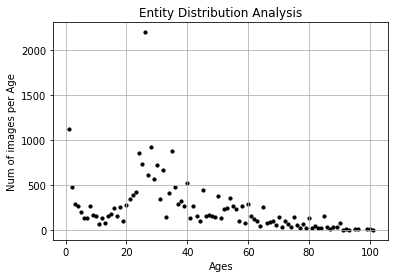

label		Age		Count
1 		 1 		 1123
2 		 2 		 482
3 		 3 		 289
4 		 4 		 273
5 		 5 		 196
6 		 6 		 131
7 		 7 		 139
8 		 8 		 263
9 		 9 		 166
10 		 10 		 156
11 		 11 		 65
12 		 12 		 130
13 		 13 		 81
14 		 14 		 157
15 		 15 		 177
16 		 16 		 247
17 		 17 		 158
18 		 18 		 262
19 		 19 		 98
20 		 20 		 284
21 		 21 		 346
22 		 22 		 395
23 		 23 		 426
24 		 24 		 859
25 		 25 		 734
26 		 26 		 2197
27 		 27 		 615
28 		 28 		 918
29 		 29 		 570
30 		 30 		 724
31 		 31 		 350
32 		 32 		 664
33 		 33 		 143
34 		 34 		 409
35 		 35 		 880
36 		 36 		 483
37 		 37 		 293
38 		 38 		 325
39 		 39 		 266
40 		 40 		 526
41 		 41 		 132
42 		 42 		 266
43 		 43 		 157
44 		 44 		 100
45 		 45 		 440
46 		 46 		 153
47 		 47 		 170
48 		 48 		 153
49 		 49 		 148
50 		 50 		 381
51 		 51 		 138
52 		 52 		 232
53 		 53 		 241
54 		 54 		 353
55 		 55 		 268
56 		 56 		 236
57 		 57 		 97
58 		 58 		 271
59 		 59 		 82
60 		 60 		 293
61 		 61 		 161
62 		 62 		 125
63 		 63 		

In [ ]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [ ]:
len(train_loader)

371

In [ ]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [ ]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [ ]:
# torch.sigmoid(logits)

In [ ]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [ ]:
# _, idx = torch.max(t2, dim=1)
# idx

**Initialise Model & Optimizer**

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# model.linear_1_bias.shape

In [ ]:
# model.linear_1_bias

In [ ]:
print(model)

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [ ]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [ ]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [ ]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/371 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Correct Train Preds: 25
Epoch: 1/100 
--------------------------------------------------------------------
Training MAE: 28.392
Training_Cost: 32.853
Training_Acc: 0.106%
Time elapsed: 85.745mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 71
Epoch: 2/100 
--------------------------------------------------------------------
Training MAE: 25.091
Training_Cost: 33.189
Training_Acc: 0.300%
Time elapsed: 92.852mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 117
Epoch: 3/100 
--------------------------------------------------------------------
Training MAE: 22.177
Training_Cost: 35.984
Training_Acc: 0.494%
Time elapsed: 100.041mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 243
Epoch: 4/100 
--------------------------------------------------------------------
Training MAE: 19.017
Training_Cost: 36.584
Training_Acc: 1.026%
Time elapsed: 107.239mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 470
Epoch: 5/100 
--------------------------------------------------------------------
Training MAE: 15.699
Training_Cost: 34.458
Training_Acc: 1.984%
Time elapsed: 114.432mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 805
Epoch: 6/100 
--------------------------------------------------------------------
Training MAE: 12.249
Training_Cost: 41.974
Training_Acc: 3.398%
Time elapsed: 121.618mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 991
Epoch: 7/100 
--------------------------------------------------------------------
Training MAE: 10.671
Training_Cost: 30.190
Training_Acc: 4.183%
Time elapsed: 128.787mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1199
Epoch: 8/100 
--------------------------------------------------------------------
Training MAE: 8.669
Training_Cost: 29.777
Training_Acc: 5.061%
Time elapsed: 135.960mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1245
Epoch: 9/100 
--------------------------------------------------------------------
Training MAE: 7.870
Training_Cost: 24.489
Training_Acc: 5.256%
Time elapsed: 143.142mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1308
Epoch: 10/100 
--------------------------------------------------------------------
Training MAE: 7.215
Training_Cost: 26.762
Training_Acc: 5.522%
Time elapsed: 150.337mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1304
Epoch: 11/100 
--------------------------------------------------------------------
Training MAE: 7.007
Training_Cost: 20.814
Training_Acc: 5.505%
Time elapsed: 157.539mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1326
Epoch: 12/100 
--------------------------------------------------------------------
Training MAE: 6.922
Training_Cost: 20.811
Training_Acc: 5.598%
Time elapsed: 164.716mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1347
Epoch: 13/100 
--------------------------------------------------------------------
Training MAE: 6.506
Training_Cost: 26.162
Training_Acc: 5.686%
Time elapsed: 171.901mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1367
Epoch: 14/100 
--------------------------------------------------------------------
Training MAE: 6.537
Training_Cost: 32.691
Training_Acc: 5.771%
Time elapsed: 179.085mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1500
Epoch: 15/100 
--------------------------------------------------------------------
Training MAE: 6.182
Training_Cost: 18.145
Training_Acc: 6.332%
Time elapsed: 186.273mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1564
Epoch: 16/100 
--------------------------------------------------------------------
Training MAE: 5.894
Training_Cost: 21.521
Training_Acc: 6.602%
Time elapsed: 193.470mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1598
Epoch: 17/100 
--------------------------------------------------------------------
Training MAE: 5.785
Training_Cost: 17.186
Training_Acc: 6.746%
Time elapsed: 200.670mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1696
Epoch: 18/100 
--------------------------------------------------------------------
Training MAE: 5.584
Training_Cost: 14.107
Training_Acc: 7.159%
Time elapsed: 207.872mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1739
Epoch: 19/100 
--------------------------------------------------------------------
Training MAE: 5.427
Training_Cost: 13.799
Training_Acc: 7.341%
Time elapsed: 215.063mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1821
Epoch: 20/100 
--------------------------------------------------------------------
Training MAE: 5.213
Training_Cost: 12.191
Training_Acc: 7.687%
Time elapsed: 222.231mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1871
Epoch: 21/100 
--------------------------------------------------------------------
Training MAE: 5.093
Training_Cost: 13.295
Training_Acc: 7.898%
Time elapsed: 229.374mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1925
Epoch: 22/100 
--------------------------------------------------------------------
Training MAE: 4.871
Training_Cost: 18.134
Training_Acc: 8.126%
Time elapsed: 236.493mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 1966
Epoch: 23/100 
--------------------------------------------------------------------
Training MAE: 5.012
Training_Cost: 14.758
Training_Acc: 8.299%
Time elapsed: 243.604mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2105
Epoch: 24/100 
--------------------------------------------------------------------
Training MAE: 4.550
Training_Cost: 22.147
Training_Acc: 8.886%
Time elapsed: 250.710mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2162
Epoch: 25/100 
--------------------------------------------------------------------
Training MAE: 4.408
Training_Cost: 14.614
Training_Acc: 9.127%
Time elapsed: 257.834mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2279
Epoch: 26/100 
--------------------------------------------------------------------
Training MAE: 4.192
Training_Cost: 13.412
Training_Acc: 9.620%
Time elapsed: 264.970mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2339
Epoch: 27/100 
--------------------------------------------------------------------
Training MAE: 4.070
Training_Cost: 17.563
Training_Acc: 9.874%
Time elapsed: 272.109mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2470
Epoch: 28/100 
--------------------------------------------------------------------
Training MAE: 3.951
Training_Cost: 11.168
Training_Acc: 10.427%
Time elapsed: 279.214mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2441
Epoch: 29/100 
--------------------------------------------------------------------
Training MAE: 3.877
Training_Cost: 13.517
Training_Acc: 10.304%
Time elapsed: 286.334mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2463
Epoch: 30/100 
--------------------------------------------------------------------
Training MAE: 3.814
Training_Cost: 13.032
Training_Acc: 10.397%
Time elapsed: 293.446mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2467
Epoch: 31/100 
--------------------------------------------------------------------
Training MAE: 3.907
Training_Cost: 11.610
Training_Acc: 10.414%
Time elapsed: 300.581mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2681
Epoch: 32/100 
--------------------------------------------------------------------
Training MAE: 3.544
Training_Cost: 13.791
Training_Acc: 11.317%
Time elapsed: 307.691mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2810
Epoch: 33/100 
--------------------------------------------------------------------
Training MAE: 3.356
Training_Cost: 10.451
Training_Acc: 11.862%
Time elapsed: 314.816mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2896
Epoch: 34/100 
--------------------------------------------------------------------
Training MAE: 3.246
Training_Cost: 9.005
Training_Acc: 12.225%
Time elapsed: 321.945mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 2943
Epoch: 35/100 
--------------------------------------------------------------------
Training MAE: 3.218
Training_Cost: 9.584
Training_Acc: 12.423%
Time elapsed: 329.069mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3149
Epoch: 36/100 
--------------------------------------------------------------------
Training MAE: 3.065
Training_Cost: 10.731
Training_Acc: 13.293%
Time elapsed: 336.193mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3051
Epoch: 37/100 
--------------------------------------------------------------------
Training MAE: 3.031
Training_Cost: 10.184
Training_Acc: 12.879%
Time elapsed: 343.322mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3123
Epoch: 38/100 
--------------------------------------------------------------------
Training MAE: 2.930
Training_Cost: 9.529
Training_Acc: 13.183%
Time elapsed: 350.428mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3189
Epoch: 39/100 
--------------------------------------------------------------------
Training MAE: 2.881
Training_Cost: 10.244
Training_Acc: 13.462%
Time elapsed: 357.556mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3377
Epoch: 40/100 
--------------------------------------------------------------------
Training MAE: 2.781
Training_Cost: 8.066
Training_Acc: 14.256%
Time elapsed: 364.677mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3288
Epoch: 41/100 
--------------------------------------------------------------------
Training MAE: 2.771
Training_Cost: 8.650
Training_Acc: 13.880%
Time elapsed: 371.793mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3397
Epoch: 42/100 
--------------------------------------------------------------------
Training MAE: 2.692
Training_Cost: 7.782
Training_Acc: 14.340%
Time elapsed: 378.908mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3542
Epoch: 43/100 
--------------------------------------------------------------------
Training MAE: 2.597
Training_Cost: 11.903
Training_Acc: 14.952%
Time elapsed: 386.013mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3420
Epoch: 44/100 
--------------------------------------------------------------------
Training MAE: 2.675
Training_Cost: 8.709
Training_Acc: 14.437%
Time elapsed: 393.155mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3550
Epoch: 45/100 
--------------------------------------------------------------------
Training MAE: 2.642
Training_Cost: 7.998
Training_Acc: 14.986%
Time elapsed: 400.304mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3747
Epoch: 46/100 
--------------------------------------------------------------------
Training MAE: 2.411
Training_Cost: 8.046
Training_Acc: 15.817%
Time elapsed: 407.438mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4006
Epoch: 47/100 
--------------------------------------------------------------------
Training MAE: 2.277
Training_Cost: 7.803
Training_Acc: 16.911%
Time elapsed: 414.576mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4002
Epoch: 48/100 
--------------------------------------------------------------------
Training MAE: 2.278
Training_Cost: 7.876
Training_Acc: 16.894%
Time elapsed: 421.717mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4051
Epoch: 49/100 
--------------------------------------------------------------------
Training MAE: 2.236
Training_Cost: 7.682
Training_Acc: 17.101%
Time elapsed: 428.848mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4090
Epoch: 50/100 
--------------------------------------------------------------------
Training MAE: 2.244
Training_Cost: 8.140
Training_Acc: 17.265%
Time elapsed: 435.973mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3700
Epoch: 51/100 
--------------------------------------------------------------------
Training MAE: 2.547
Training_Cost: 11.005
Training_Acc: 15.619%
Time elapsed: 443.094mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3122
Epoch: 52/100 
--------------------------------------------------------------------
Training MAE: 3.043
Training_Cost: 7.114
Training_Acc: 13.179%
Time elapsed: 450.220mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4160
Epoch: 53/100 
--------------------------------------------------------------------
Training MAE: 2.152
Training_Cost: 5.663
Training_Acc: 17.561%
Time elapsed: 457.343mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4527
Epoch: 54/100 
--------------------------------------------------------------------
Training MAE: 1.936
Training_Cost: 7.059
Training_Acc: 19.110%
Time elapsed: 464.464mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4729
Epoch: 55/100 
--------------------------------------------------------------------
Training MAE: 1.880
Training_Cost: 9.125
Training_Acc: 19.963%
Time elapsed: 471.577mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4712
Epoch: 56/100 
--------------------------------------------------------------------
Training MAE: 1.872
Training_Cost: 8.550
Training_Acc: 19.891%
Time elapsed: 478.709mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4663
Epoch: 57/100 
--------------------------------------------------------------------
Training MAE: 1.919
Training_Cost: 7.554
Training_Acc: 19.684%
Time elapsed: 485.841mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4646
Epoch: 58/100 
--------------------------------------------------------------------
Training MAE: 1.939
Training_Cost: 10.768
Training_Acc: 19.612%
Time elapsed: 492.969mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3538
Epoch: 59/100 
--------------------------------------------------------------------
Training MAE: 2.740
Training_Cost: 6.546
Training_Acc: 14.935%
Time elapsed: 500.101mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4395
Epoch: 60/100 
--------------------------------------------------------------------
Training MAE: 2.021
Training_Cost: 6.959
Training_Acc: 18.553%
Time elapsed: 507.231mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4893
Epoch: 61/100 
--------------------------------------------------------------------
Training MAE: 1.777
Training_Cost: 7.625
Training_Acc: 20.655%
Time elapsed: 514.376mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5105
Epoch: 62/100 
--------------------------------------------------------------------
Training MAE: 1.732
Training_Cost: 6.242
Training_Acc: 21.550%
Time elapsed: 521.513mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5076
Epoch: 63/100 
--------------------------------------------------------------------
Training MAE: 1.700
Training_Cost: 7.976
Training_Acc: 21.428%
Time elapsed: 528.656mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5055
Epoch: 64/100 
--------------------------------------------------------------------
Training MAE: 1.724
Training_Cost: 8.419
Training_Acc: 21.339%
Time elapsed: 535.790mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5016
Epoch: 65/100 
--------------------------------------------------------------------
Training MAE: 1.754
Training_Cost: 6.799
Training_Acc: 21.174%
Time elapsed: 542.904mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5010
Epoch: 66/100 
--------------------------------------------------------------------
Training MAE: 1.750
Training_Cost: 5.820
Training_Acc: 21.149%
Time elapsed: 550.013mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5111
Epoch: 67/100 
--------------------------------------------------------------------
Training MAE: 1.717
Training_Cost: 4.131
Training_Acc: 21.575%
Time elapsed: 557.162mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5147
Epoch: 68/100 
--------------------------------------------------------------------
Training MAE: 1.722
Training_Cost: 6.938
Training_Acc: 21.727%
Time elapsed: 564.298mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5221
Epoch: 69/100 
--------------------------------------------------------------------
Training MAE: 1.681
Training_Cost: 4.876
Training_Acc: 22.040%
Time elapsed: 571.444mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5356
Epoch: 70/100 
--------------------------------------------------------------------
Training MAE: 1.668
Training_Cost: 5.943
Training_Acc: 22.610%
Time elapsed: 578.567mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5006
Epoch: 71/100 
--------------------------------------------------------------------
Training MAE: 1.945
Training_Cost: 7.589
Training_Acc: 21.132%
Time elapsed: 585.699mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3659
Epoch: 72/100 
--------------------------------------------------------------------
Training MAE: 2.729
Training_Cost: 8.317
Training_Acc: 15.446%
Time elapsed: 592.816mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4672
Epoch: 73/100 
--------------------------------------------------------------------
Training MAE: 1.952
Training_Cost: 4.909
Training_Acc: 19.722%
Time elapsed: 599.936mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5566
Epoch: 74/100 
--------------------------------------------------------------------
Training MAE: 1.568
Training_Cost: 6.302
Training_Acc: 23.496%
Time elapsed: 607.064mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6075
Epoch: 75/100 
--------------------------------------------------------------------
Training MAE: 1.432
Training_Cost: 5.171
Training_Acc: 25.645%
Time elapsed: 614.183mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6123
Epoch: 76/100 
--------------------------------------------------------------------
Training MAE: 1.412
Training_Cost: 6.555
Training_Acc: 25.847%
Time elapsed: 621.312mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6111
Epoch: 77/100 
--------------------------------------------------------------------
Training MAE: 1.410
Training_Cost: 5.837
Training_Acc: 25.797%
Time elapsed: 628.423mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6243
Epoch: 78/100 
--------------------------------------------------------------------
Training MAE: 1.409
Training_Cost: 4.729
Training_Acc: 26.354%
Time elapsed: 635.526mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6193
Epoch: 79/100 
--------------------------------------------------------------------
Training MAE: 1.414
Training_Cost: 5.306
Training_Acc: 26.143%
Time elapsed: 642.634mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6230
Epoch: 80/100 
--------------------------------------------------------------------
Training MAE: 1.407
Training_Cost: 5.195
Training_Acc: 26.299%
Time elapsed: 649.751mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6082
Epoch: 81/100 
--------------------------------------------------------------------
Training MAE: 1.476
Training_Cost: 5.489
Training_Acc: 25.674%
Time elapsed: 656.879mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6103
Epoch: 82/100 
--------------------------------------------------------------------
Training MAE: 1.484
Training_Cost: 5.674
Training_Acc: 25.763%
Time elapsed: 664.026mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6039
Epoch: 83/100 
--------------------------------------------------------------------
Training MAE: 1.514
Training_Cost: 3.958
Training_Acc: 25.493%
Time elapsed: 671.163mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6240
Epoch: 84/100 
--------------------------------------------------------------------
Training MAE: 1.462
Training_Cost: 4.675
Training_Acc: 26.341%
Time elapsed: 678.313mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6370
Epoch: 85/100 
--------------------------------------------------------------------
Training MAE: 1.443
Training_Cost: 4.887
Training_Acc: 26.890%
Time elapsed: 685.445mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6456
Epoch: 86/100 
--------------------------------------------------------------------
Training MAE: 1.430
Training_Cost: 4.479
Training_Acc: 27.253%
Time elapsed: 692.599mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6491
Epoch: 87/100 
--------------------------------------------------------------------
Training MAE: 1.431
Training_Cost: 4.280
Training_Acc: 27.401%
Time elapsed: 699.758mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6268
Epoch: 88/100 
--------------------------------------------------------------------
Training MAE: 1.508
Training_Cost: 5.290
Training_Acc: 26.460%
Time elapsed: 706.905mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6529
Epoch: 89/100 
--------------------------------------------------------------------
Training MAE: 1.430
Training_Cost: 4.677
Training_Acc: 27.561%
Time elapsed: 714.051mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6779
Epoch: 90/100 
--------------------------------------------------------------------
Training MAE: 1.365
Training_Cost: 4.155
Training_Acc: 28.617%
Time elapsed: 721.193mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6968
Epoch: 91/100 
--------------------------------------------------------------------
Training MAE: 1.303
Training_Cost: 3.944
Training_Acc: 29.414%
Time elapsed: 728.331mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7110
Epoch: 92/100 
--------------------------------------------------------------------
Training MAE: 1.310
Training_Cost: 4.262
Training_Acc: 30.014%
Time elapsed: 735.464mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6839
Epoch: 93/100 
--------------------------------------------------------------------
Training MAE: 1.386
Training_Cost: 3.515
Training_Acc: 28.870%
Time elapsed: 742.575mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6703
Epoch: 94/100 
--------------------------------------------------------------------
Training MAE: 1.415
Training_Cost: 5.580
Training_Acc: 28.296%
Time elapsed: 749.708mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6857
Epoch: 95/100 
--------------------------------------------------------------------
Training MAE: 1.385
Training_Cost: 5.009
Training_Acc: 28.946%
Time elapsed: 756.870mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6868
Epoch: 96/100 
--------------------------------------------------------------------
Training MAE: 1.379
Training_Cost: 3.165
Training_Acc: 28.992%
Time elapsed: 763.998mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7439
Epoch: 97/100 
--------------------------------------------------------------------
Training MAE: 1.264
Training_Cost: 3.857
Training_Acc: 31.403%
Time elapsed: 771.140mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7464
Epoch: 98/100 
--------------------------------------------------------------------
Training MAE: 1.241
Training_Cost: 5.760
Training_Acc: 31.508%
Time elapsed: 778.274mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7573
Epoch: 99/100 
--------------------------------------------------------------------
Training MAE: 1.218
Training_Cost: 6.128
Training_Acc: 31.968%
Time elapsed: 785.401mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7066
Epoch: 100/100 
--------------------------------------------------------------------
Training MAE: 1.373
Training_Cost: 5.311
Training_Acc: 29.828%
Time elapsed: 792.530mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

In [ ]:
# for i in range(26, 200):
#   print(i)